## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')

root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path,
                                                        train=True,
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path,
                                                       train=False,
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

100%|██████████| 26421880/26421880 [00:02<00:00, 12423706.15it/s]


Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 205457.09it/s]


Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3862450.95it/s]


Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6499782.36it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


Информация о датасете с кагла:

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.BatchNorm1d(input_shape),
            nn.Dropout(0.3),
            nn.Linear(input_shape, 392),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(392, 196),
            nn.ReLU(),
            nn.Linear(196, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)

        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
           Dropout-3                  [-1, 784]               0
            Linear-4                  [-1, 392]         307,720
              ReLU-5                  [-1, 392]               0
           Dropout-6                  [-1, 392]               0
            Linear-7                  [-1, 196]          77,028
              ReLU-8                  [-1, 196]               0
            Linear-9                   [-1, 10]           1,970
       LogSoftmax-10                   [-1, 10]               0
Total params: 388,286
Trainable params: 388,286
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 1.48
Estimated T

Your experiments come here:

In [15]:
def accuracy(logit, target, batch_size):
  corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
  acc = 100.0*corrects/batch_size
  return acc.item()


def train_model(model, train_loader, val_loader, loss_func, opt, n_epochs: int):
    train_loss = []
    val_loss = []
    val_accuracy = []
    train_accuracy = []

    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_val_accuracy = []
        ep_train_accuracy = []

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)


            logits = model.forward(X_batch)

            loss = loss_func(logits, y_batch)
            opt.zero_grad()
            loss.backward()
            opt.step()

            ep_train_loss.append(loss.item())
            y_pred = logits.max(dim=1)[1]
            ep_train_accuracy.append(((y_pred==y_batch).detach().cpu().numpy().mean()))

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                y_pred = model.forward(X_batch)
                loss = loss_func(y_pred, y_batch)
                ep_val_loss.append(loss.item())
                y_pred = y_pred.max(dim=1)[1]

                ep_val_accuracy.append(((y_pred==y_batch).detach().cpu().numpy().mean()))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs}')

        train_loss.append(np.mean(ep_train_loss))
        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))
        train_accuracy.append(np.mean(ep_train_accuracy))

        print(f"\t  training loss: {train_loss[-1]:.6f}")
        print(f"\tvalidation loss: {val_loss[-1]:.6f}")
        print(f"\tvalidation accuracy: {val_accuracy[-1]:.3f}")
        print(f"\ttrain accuracy: {train_accuracy[-1]:.3f}")

    return train_loss, val_loss, val_accuracy, train_accuracy

def plot_train_process(train_loss, val_loss, val_accuracy, train_accuracy):
    plt.rcParams['axes.grid'] = True
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(val_loss, label='validation')

    axes[0].legend()

    axes[1].set_title('Accuracy')
    axes[1].plot(train_accuracy, label='train')
    axes[1].plot(val_accuracy, label='validation')
    axes[1].legend()

def get_acc(test_loader):
  test_acc=0.0
  for i, (images, labels) in enumerate(test_loader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outs = model(images)
    test_acc += accuracy(outs, labels, 256)

  return test_acc/i

Epoch 1 of 10
	  training loss: 0.519548
	validation loss: 0.397377
	validation accuracy: 0.854
	train accuracy: 0.812
Epoch 2 of 10
	  training loss: 0.402192
	validation loss: 0.362356
	validation accuracy: 0.867
	train accuracy: 0.853
Epoch 3 of 10
	  training loss: 0.368545
	validation loss: 0.346816
	validation accuracy: 0.871
	train accuracy: 0.861
Epoch 4 of 10
	  training loss: 0.351696
	validation loss: 0.329923
	validation accuracy: 0.876
	train accuracy: 0.868
Epoch 5 of 10
	  training loss: 0.337427
	validation loss: 0.333140
	validation accuracy: 0.877
	train accuracy: 0.874
Epoch 6 of 10
	  training loss: 0.325502
	validation loss: 0.321018
	validation accuracy: 0.882
	train accuracy: 0.878
Epoch 7 of 10
	  training loss: 0.312210
	validation loss: 0.306984
	validation accuracy: 0.890
	train accuracy: 0.884
Epoch 8 of 10
	  training loss: 0.303355
	validation loss: 0.318391
	validation accuracy: 0.884
	train accuracy: 0.885
Epoch 9 of 10
	  training loss: 0.298232
	valida

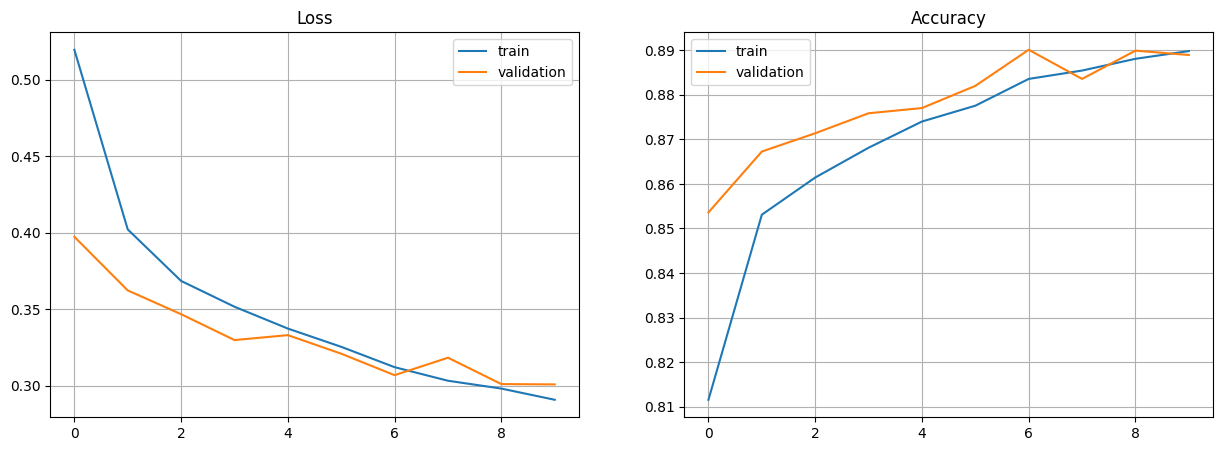

In [18]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
n_epochs = 10


train_loss, val_loss, val_accuracy, train_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

plot_train_process(train_loss, val_loss, val_accuracy, train_accuracy)

In [19]:
get_acc(test_loader)

89.07251602564102

Требуемая точность достигнута, переобучения на графие лоссов не наблюдается - он снижается для и для тестовой, и для трейновой выборки

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [21]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.Linear(input_shape, 392),
            nn.ReLU(),
            nn.Linear(392, 320),
            nn.ReLU(),
            nn.Linear(320, 280),
            nn.ReLU(),
            nn.Linear(280, 220),
            nn.ReLU(),
            nn.Linear(220, 220),
            nn.ReLU(),
            nn.Linear(220, 180),
            nn.ReLU(),
            nn.Linear(180, 120),
            nn.ReLU(),
            nn.Linear(120, 80),
            nn.ReLU(),
            nn.Linear(80, 20),
            nn.ReLU(),
            nn.Linear(20, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [22]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
            Linear-3                  [-1, 784]         615,440
              ReLU-4                  [-1, 784]               0
            Linear-5                  [-1, 392]         307,720
              ReLU-6                  [-1, 392]               0
            Linear-7                  [-1, 320]         125,760
              ReLU-8                  [-1, 320]               0
            Linear-9                  [-1, 280]          89,880
             ReLU-10                  [-1, 280]               0
           Linear-11                  [-1, 220]          61,820
             ReLU-12                  [-1, 220]               0
           Linear-13                  [-1, 220]          48,620
             ReLU-14                  [

In [23]:
numbers = np.random.randint(0, high=len(fmnist_dataset_train), size=2000, dtype=int)
short_train = torch.utils.data.Subset(fmnist_dataset_train, numbers)
len(short_train)

2000

In [24]:

train_loader_short = torch.utils.data.DataLoader(short_train,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

Epoch 1 of 40
	  training loss: 2.199540
	validation loss: 1.934111
	validation accuracy: 0.321
	train accuracy: 0.187
Epoch 2 of 40
	  training loss: 1.474854
	validation loss: 1.275149
	validation accuracy: 0.466
	train accuracy: 0.451
Epoch 3 of 40
	  training loss: 1.068623
	validation loss: 0.999299
	validation accuracy: 0.599
	train accuracy: 0.549
Epoch 4 of 40
	  training loss: 0.813832
	validation loss: 0.878794
	validation accuracy: 0.639
	train accuracy: 0.661
Epoch 5 of 40
	  training loss: 0.725041
	validation loss: 0.824711
	validation accuracy: 0.655
	train accuracy: 0.695
Epoch 6 of 40
	  training loss: 0.656773
	validation loss: 0.832119
	validation accuracy: 0.683
	train accuracy: 0.709
Epoch 7 of 40
	  training loss: 0.602151
	validation loss: 0.828232
	validation accuracy: 0.725
	train accuracy: 0.736
Epoch 8 of 40
	  training loss: 0.599282
	validation loss: 0.999957
	validation accuracy: 0.670
	train accuracy: 0.765
Epoch 9 of 40
	  training loss: 0.538763
	valida

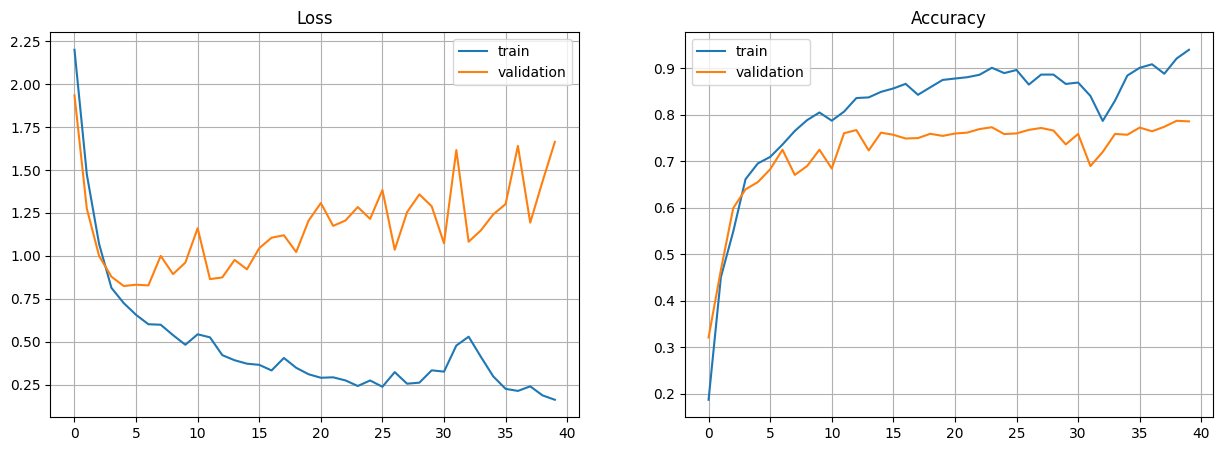

In [25]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
n_epochs = 40


train_loss, val_loss, val_accuracy, train_acc = train_model(model, train_loader_short, test_loader, loss_func, opt, n_epochs)

plot_train_process(train_loss, val_loss, val_accuracy, train_acc)

Как реализован overfitting?
- добавлено множество дополнительных линейных слоев в модель
- уменьшен размер трейнового сета до 2000
- увеличено количество эпох обучения - 40

На графике видно, что трейновый лосс падает одновременно с увеличенем лосса на тестовой выборке - переобучение наблюдается уже после 5 эпохи

In [26]:
get_acc(test_loader)

78.45552884615384

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

In [27]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.BatchNorm1d(input_shape),
            nn.Dropout(0.5),
            nn.Linear(input_shape, input_shape),
            nn.ReLU(),
            nn.BatchNorm1d(input_shape),
            nn.Linear(input_shape, 392),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(392, 320),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.BatchNorm1d(320),
            nn.Linear(320, 280),
            nn.ReLU(),
            nn.Linear(280, 220),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(220, 220),
            nn.ReLU(),
            nn.BatchNorm1d(220),
            nn.Linear(220, 180),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(180, 120),
            nn.ReLU(),
            nn.BatchNorm1d(120),
            nn.Linear(120, 80),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(80, 20),
            nn.ReLU(),
            nn.Linear(20, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

In [28]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]           1,568
           Dropout-3                  [-1, 784]               0
            Linear-4                  [-1, 784]         615,440
              ReLU-5                  [-1, 784]               0
       BatchNorm1d-6                  [-1, 784]           1,568
            Linear-7                  [-1, 392]         307,720
              ReLU-8                  [-1, 392]               0
           Dropout-9                  [-1, 392]               0
           Linear-10                  [-1, 320]         125,760
          Dropout-11                  [-1, 320]               0
             ReLU-12                  [-1, 320]               0
      BatchNorm1d-13                  [-1, 320]             640
           Linear-14                  [

Epoch 1 of 40
	  training loss: 2.252830
	validation loss: 2.289236
	validation accuracy: 0.102
	train accuracy: 0.130
Epoch 2 of 40
	  training loss: 1.919568
	validation loss: 1.722593
	validation accuracy: 0.396
	train accuracy: 0.358
Epoch 3 of 40
	  training loss: 1.493617
	validation loss: 1.215594
	validation accuracy: 0.556
	train accuracy: 0.463
Epoch 4 of 40
	  training loss: 1.159296
	validation loss: 0.950450
	validation accuracy: 0.662
	train accuracy: 0.575
Epoch 5 of 40
	  training loss: 0.901525
	validation loss: 0.797419
	validation accuracy: 0.700
	train accuracy: 0.690
Epoch 6 of 40
	  training loss: 0.794014
	validation loss: 0.765764
	validation accuracy: 0.706
	train accuracy: 0.708
Epoch 7 of 40
	  training loss: 0.724085
	validation loss: 0.684441
	validation accuracy: 0.759
	train accuracy: 0.739
Epoch 8 of 40
	  training loss: 0.658542
	validation loss: 0.727413
	validation accuracy: 0.753
	train accuracy: 0.758
Epoch 9 of 40
	  training loss: 0.623968
	valida

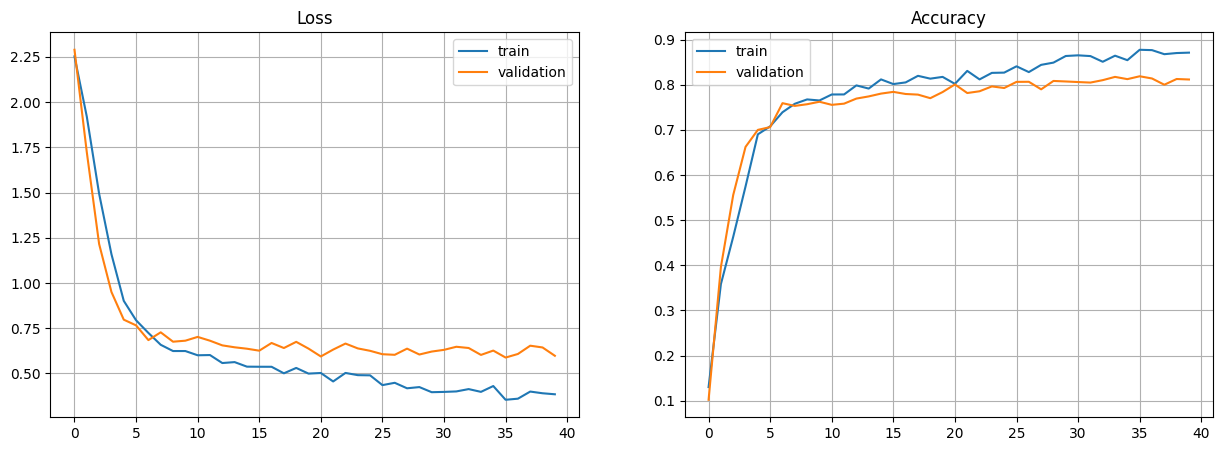

In [29]:
model = FixedNeuralNetwork().to(device)
opt  = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = nn.CrossEntropyLoss()
n_epochs = 40


train_loss, val_loss, val_accuracy, train_acc = train_model(model, train_loader_short, test_loader, loss_func, opt, n_epochs)

plot_train_process(train_loss, val_loss, val_accuracy, train_acc)

Внесла изменения только в структуру модели - добавила много BN's и DropOut's и запустила ее на коротком трейне (длиной 2000) и с тем же количеством эпох (40), как и для переобученной сети.

На графике явного переобучения не наблюдается - тестовый лосс хотя бы не растет, также увеличалась точность по сравнению со вторым пунктом. Но 40 эпох - все равно слишком много для такой сети, после 20 эпохи тестовый лосс довольно константный.

In [30]:
get_acc(test_loader)

81.28004807692308

### Conclusions:
_Write down small report with your conclusions and your ideas._

1. даже с помощью одних линейных слоев можно более-менее классифицировать изображения, если считать точность порядка 0.89 приемлемой
2. по результатам экспериментов пункта 2 и 3 можно сделать вывод, что причины переобучения модели во многом скрываются в ее внутренней структуре: при том же коротком трейновом сете и количестве эпох явного переобучения в пункте 3 не наблюдается, тестовый лосс просто остается постоянным. В прочем, это не отменяет того, что данные параметры имеют прямое влияние на переобучение.
3. главная идея для меня - не нужно перегружать модель) в части 1 модель имела всего 388,286 параметров и уже могла выдавать приемлемую классификацию. В части 2 у модели уже 1,323,818 параметров, что требует довольно много вычислительных ресурсов, но качество при этом понизилось. В части 3 с помощью 5 BN's и 6 DO's получилось улучшить качество, задействовав 1,326,706 параметров, но точность классификации все равно не меньше чем достигнутая в пункте 1